In [44]:
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [106]:
def f(x):
  return 5*x**2

def dydx(x):
  return 10*x

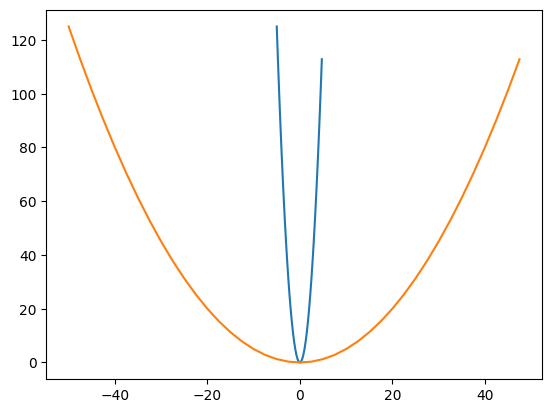

In [107]:

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
zs = dydx(xs)
plt.plot(xs, ys)
plt.plot(zs, ys)

# Derivative Basic

In [24]:
h = 0.01
x = -3
(f(x + h) - f(x))/h

-15.969999999999729

In [255]:
class Value:
  def __init__(self, val, _children = (), _op="", label = ""):
    self.data = val 
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None
  
  def __repr__(self):
    return f"Value(data = {self.data})"

  def __radd__(self, other):
    return self + other

  def __rmul__(self, other):
    return self * other

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")
    def backward():
      self.grad += out.grad * 1.0
      other.grad += out.grad * 1.0

    out._backward = backward
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), "exp")
    def backward():
      self.grad += out.data * out.grad
    out._backward = backward
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")
    def backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = backward
    return out
  
  def tanh(self):
    other = other if isinstance(other, Value) else Value(other)
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")
    def backward():
      out.grad += (1 - t**2) * out.grad
    out._backward = backward 
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(node):
      if node not in visited:
        visited.add(node)
        for child in node._prev:
          build_topo(child)
        topo.append(node)
      
    build_topo(self) 
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [204]:
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = '{ %s | data %.4f | %s }' % (n.label, n.data, n.grad), shape="record")
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  
  return dot

In [205]:

a = Value(10, label="a")
b = Value(2, label="b")
c = Value(3, label="c")
d = Value(5, label="d")


z = ((a * b) + c) * d

In [206]:
def un_pollute(a, b, c, d):
  x = a * b; x.label = "x"
  y = x + c; y.label = "y"
  z = y * d; z.label = "z"
  return z



In [253]:

h = 0.5
d1 = un_pollute(a + Value(h), b, c, d )
d1

Value(data = 120.0)

In [208]:

d2 = un_pollute(a, b, c, d)
d2

Value(data = 115)

In [248]:
(d1.data - d2.data)/h


10.0

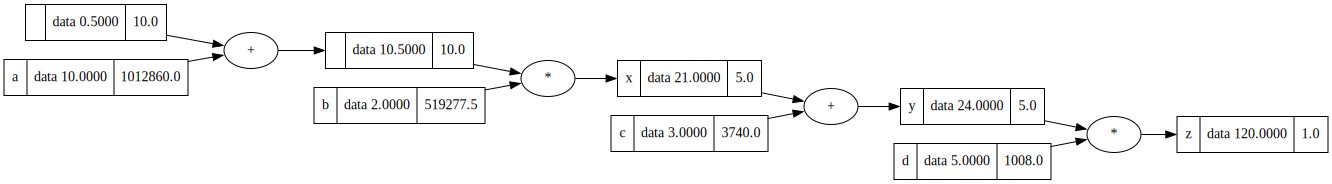

In [254]:
d1.backward()
draw_dot(d1)